In [1]:
import torch as t
from utils import DataManager
import random
import matplotlib.pyplot as plt
import random
from probes import LRProbe, MMProbe, CCSProbe
import configparser
import json

Matplotlib created a temporary cache directory at /tmp/matplotlib-nujckndk because the default path (/share/u/smarks/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# hyperparameters
model = 'llama-2-7b'
split = 0.8
device = 'cuda:0' if t.cuda.is_available() else 'cpu'

config = configparser.ConfigParser()
config.read('config.ini')
layer = eval(config[model]['probe_layer'])
noperiod = eval(config[model]['noperiod'])

# Reproducing generalization matrix

In [3]:
train_medlies  = [
    ['cities'],
    ['cities', 'neg_cities'],
    ['larger_than'],
    ['larger_than', 'smaller_than'],
    ['likely']
]

val_datasets = [
    'cities',
    'neg_cities',
    'larger_than',
    'smaller_than',
    'sp_en_trans',
    'neg_sp_en_trans',
    'cities_cities_conj',
    'cities_cities_disj',
    'companies_true_false',
    'common_claim_true_false',
    'counterfact_true_false'    
]

def to_str(l):
    return '+'.join(l)

ProbeClasses = [
    LRProbe, 
    MMProbe, 
    ]

accs = {str(probe_class) : {to_str(train_medley) : {} for train_medley in train_medlies} for probe_class in ProbeClasses}

seed = random.randint(0, 100000)

for ProbeClass in ProbeClasses:
    for medley in train_medlies:

        # set up data
        dm = DataManager()
        for dataset in medley:
            dm.add_dataset(dataset, model, layer, split=split, seed=seed, noperiod=noperiod, center=True, device=device)
        for dataset in val_datasets:
            if dataset not in medley:
                dm.add_dataset(dataset, model, layer, split=None, noperiod=noperiod, center=True, device=device)

        # train probe
        train_acts, train_labels = dm.get('train')
        probe = ProbeClass.from_data(train_acts, train_labels, device=device)
        direction = probe.direction

        # evaluate
        for val_dataset in val_datasets:
            if val_dataset in medley:
                acts, labels = dm.data['val'][val_dataset]
                accs[str(ProbeClass)][to_str(medley)][val_dataset] = (
                    probe.pred(acts, iid=True) == labels
                ).float().mean().item()
            else:
                acts, labels = dm.data[val_dataset]
                accs[str(ProbeClass)][to_str(medley)][val_dataset] = (
                    probe.pred(acts, iid=False) == labels
                ).float().mean().item()

lr_mm_accs = accs.copy()

with open('experimental_outputs/generalization_results.json', 'r') as f:
    outs = json.load(f)

for ProbeClass in ProbeClasses:
    out = accs[str(ProbeClass)]
    out['model'] = model
    out['probe'] = ProbeClass.__str__()
    out['layer'] = layer
    out['oracle'] = False
    out['noperiod'] = noperiod
    outs.append(out)

with open('experimental_outputs/generalization_results.json', 'w') as f:
    json.dump(outs, f, indent=2)

/share/u/smarks/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
ccs_medlies = [
    ['cities', 'neg_cities'],
    ['larger_than', 'smaller_than'],
]

accs = {to_str(medley) : {} for medley in ccs_medlies}

for medley in ccs_medlies:
    dm = DataManager()
    for dataset in medley:
        dm.add_dataset(dataset, model, layer, split=split, seed=seed, noperiod=noperiod, center=True, device=device)
    for dataset in val_datasets:
        if dataset not in medley:
            dm.add_dataset(dataset, model, layer, split=None, noperiod=noperiod, center=True, device=device)
    
    train_acts, train_labels = dm.data['train'][medley[0]]
    train_neg_acts, _ = dm.data['train'][medley[1]]
    probe = CCSProbe.from_data(train_acts, train_neg_acts, train_labels, device=device)

    for val_dataset in val_datasets:
        if val_dataset in medley:
            acts, labels = dm.data['val'][val_dataset]
        else:
            acts, labels = dm.data[val_dataset]
        accs[to_str(medley)][val_dataset] = (
            probe.pred(acts) == labels
        ).float().mean().item()
    
ccs_accs = accs.copy()

with open('experimental_outputs/generalization_results.json', 'r') as f:
    outs = json.load(f)

out = accs
out['model'] = model
out['probe'] = 'CCSProbe'
out['layer'] = layer
out['oracle'] = False
out['noperiod'] = noperiod
outs.append(out)

with open('experimental_outputs/generalization_results.json', 'w') as f:
    json.dump(outs, f, indent=2)

In [ ]:
# retrieve few-shot results
# !! must first run few_shot.py to populate experimental_outputs/few_shot_results.json !!
import json
with open('experimental_outputs/few_shot_results.json', 'r') as f:
    few_shot_results = json.load(f)
few_shot_accs = []
for dataset in val_datasets:
    all_accs = [d['acc'] for d in few_shot_results if (d['dataset'] == dataset and d['model'] == model)]
    few_shot_accs.append(max(all_accs))


In [25]:
# get oracle probe results
oracle_accs = {str(probe_class) : [] for probe_class in ProbeClasses}
for ProbeClass in ProbeClasses:
    for dataset in val_datasets:
        dm = DataManager()
        dm.add_dataset(dataset, model, layer, split=split, noperiod=noperiod, seed=seed, device=device)
        acts, labels = dm.get('train')
        probe = ProbeClass.from_data(acts, labels, device=device)

        acts, labels = dm.data['val'][dataset]
        acc = (probe(acts, iid=True).round() == labels).float().mean().item()
        oracle_accs[str(ProbeClass)].append(acc)

with open('experimental_outputs/generalization_results.json', 'r') as f:
    outs = json.load(f)

for ProbeClass in ProbeClasses:
    out = accs[str(ProbeClass)]
    out['model'] = model
    out['probe'] = ProbeClass.__str__()
    out['oracle'] = True
    out['layer'] = layer
    out['noperiod'] = noperiod
    outs.append(out)

with open('experimental_outputs/generalization_results.json', 'w') as f:
    json.dump(outs, f, indent=2)

In [26]:
oracle_accs

{"<class 'probes.LRProbe'>": [0.9900000095367432,
  0.9900000095367432,
  1.0,
  1.0,
  0.98591548204422,
  1.0,
  0.9766666889190674,
  0.9399999976158142,
  0.9250000715255737,
  0.7438202500343323,
  0.8548412322998047],
 "<class 'probes.MMProbe'>": [0.9833333492279053,
  0.9900000095367432,
  1.0,
  0.997474730014801,
  1.0,
  1.0,
  0.9433333277702332,
  0.9100000262260437,
  0.7291666865348816,
  0.6988764405250549,
  0.7664632797241211]}

NameError: name 'few_shot_accs' is not defined

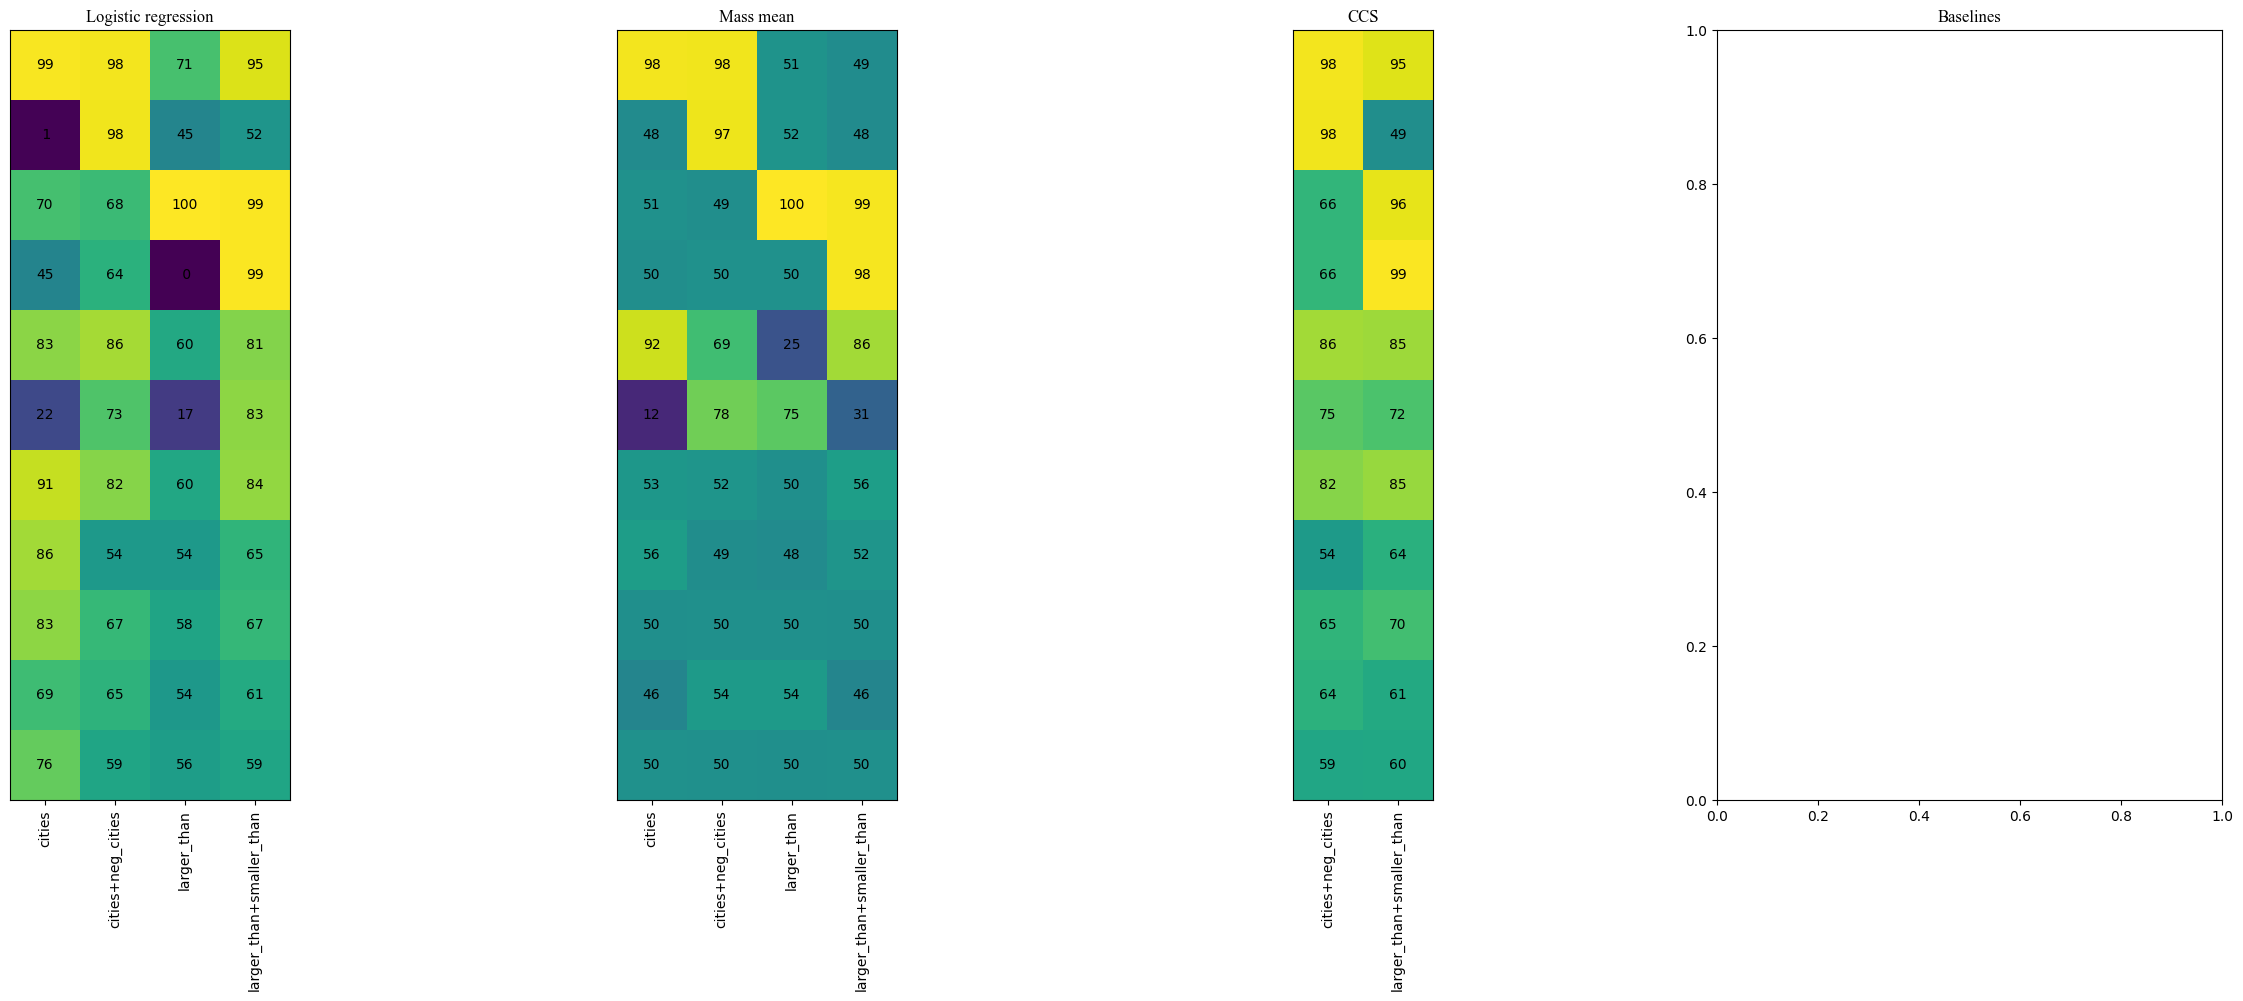

In [27]:
fig, axes = plt.subplots(1, 4, figsize=(30, 10))
for ax_idx, ax in enumerate(axes):
    if ax_idx == 0:
        ax.set_title("Logistic regression", {'fontname' : 'Times New Roman'})
        ax_accs = lr_mm_accs[str(LRProbe)]
    elif ax_idx == 1:
        ax.set_title("Mass mean", {'fontname' : 'Times New Roman'})
        ax_accs = lr_mm_accs[str(MMProbe)]
    else:
        continue # do this outside of the loop

    
    grid = [ [] for _ in val_datasets]

    for i, val_dataset in enumerate(val_datasets):
        for medley in train_medlies:
            if medley == ['likely']:
                continue # treat likely as a baseline
            grid[i].append(ax_accs[to_str(medley)][val_dataset])


    ax.imshow(grid, vmin=0, vmax=1)
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            ax.text(j, i, f'{round(grid[i][j] * 100):2d}', ha='center', va='center')

    ax.set_xticks(range(len(train_medlies) - 1))
    ax.set_xticklabels([to_str(medley) for medley in train_medlies[:-1]], rotation=90)
    ax.set_yticks([])

ax = axes[2]
ax.set_title("CCS", {'fontname' : 'Times New Roman'})
grid = [ [] for _ in val_datasets]
for i, val_dataset in enumerate(val_datasets):
    for medley in ccs_medlies:
        grid[i].append(ccs_accs[to_str(medley)][val_dataset])
ax.imshow(grid, vmin=0, vmax=1)
for i in range(len(grid)):
    for j in range(len(grid[0])):
        ax.text(j, i, f'{round(grid[i][j] * 100):2d}', ha='center', va='center')

ax.set_xticks(range(len(ccs_medlies)))
ax.set_xticklabels([to_str(medley) for medley in ccs_medlies], rotation=90)
ax.set_yticks([])


ax = axes[3]
ax.set_title("Baselines", {'fontname' : 'Times New Roman'})
grid = [ [
    lr_mm_accs[str(LRProbe)]['likely'][val_dataset],
    lr_mm_accs[str(MMProbe)]['likely'][val_dataset],
    few_shot_accs[i],
    oracle_accs[str(LRProbe)][i]
    ] for i, val_dataset in enumerate(val_datasets) 
]

ax.imshow(grid, vmin=0, vmax=1)
for i in range(len(grid)):
    for j in range(len(grid[0])):
        ax.text(j, i, f'{round(grid[i][j] * 100):2d}', ha='center', va='center')

ax.set_xticks(range(4))
ax.set_xticklabels(['LR on likely', 'MM on likely', 'calibrated 5-shot', 'LR on val set'], rotation=90)
ax.set_yticks([])

for ax in axes:
    ax.hlines([1.5, 3.5, 5.5], *ax.get_xlim(), linewidth=3, color='black')
    ax.vlines([1.5], *ax.get_ylim(), linewidth=3, color='black')

ax = axes[0]
ax.set_yticks(range(len(val_datasets)))
ax.set_yticklabels(val_datasets)


plt.colorbar(axes[0].images[0], ax=axes)
plt.show()

In [9]:
fig.savefig(f'junk/{model}/generalization_abridged.pdf')